In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import time
from datetime import datetime, timedelta
import talib
import tushare as ts
import datetime

In [2]:
start = time.time()

In [3]:
#显示所有列
pd.set_option("display.max_columns", None) 
#显示所有行，慎用，容易死机
#pd.set_option("display.max_rows", None) 
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

# 1、读入数仓数据

In [4]:
# 读取year
def read_newyear():
    df = pd.read_csv('../JN_DataWarehouse/stock_analysis/TuShare/new_year.csv' ,index_col=False)
    
    del df['Unnamed: 0']
    return df

In [5]:
df_stock_all = read_newyear()
df_stock_all.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,002007.SZ,20110104,48.51,48.69,47.42,48.13,48.39,-0.26,-0.54,50208.66,240624.7194
1,000088.SZ,20110104,6.15,6.18,6.09,6.17,6.13,0.04,0.65,22159.02,13623.5458
2,000068.SZ,20110104,6.01,6.30,5.94,6.30,6.00,0.30,5.00,109392.70,66681.5565
3,600167.SH,20110104,9.62,9.78,9.58,9.74,9.63,0.11,1.14,8403.49,8151.7650
4,002418.SZ,20110104,22.05,22.64,22.01,22.58,22.00,0.58,2.64,12609.19,28261.5130


# 2、 RSI运算

In [6]:
stock_code = '600000'
today = datetime.date.today()                #datetime.date类型日期  today = datetime.date(2019,11,15)
today = today -  datetime.timedelta(365*0)
A3yday = today - datetime.timedelta(365*0.5)
startDate = A3yday.strftime('%Y%m%d')        #字符串型日期
endDate = today.strftime('%Y%m%d')
from Stock_Interface import read_finance_year   
stock_name =  read_finance_year.read_companyInfo(stock_code)

df = df_stock_all.query("ts_code.str.startswith('"+stock_code+"')",engine='python')    
df = df.query("trade_date > "+startDate+" & trade_date < "+endDate+"")

# 日期转换
df["trade_date"] = pd.to_datetime(df["trade_date"], format='%Y%m%d')
df["trade_date"] = df['trade_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [7]:
df.tail(3)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
9921779,600000.SH,2020-11-18,9.53,9.77,9.50,9.70,9.53,0.17,1.7838,1094175.13,1059930.873
9926502,600000.SH,2020-11-19,9.70,9.78,9.64,9.74,9.70,0.04,0.4124,638400.56,620569.638
9928770,600000.SH,2020-11-20,9.68,9.72,9.61,9.67,9.74,-0.07,-0.7187,466313.60,450166.503


In [8]:
# 同花顺 KDJ 算法 , 
# rolling(9, min_periods=9).min() 是每9个数为一个窗口取最小值，不足9个为NaN
# expanding().min() 当前行的最小值
low_list = df['low'].rolling(9, min_periods=9).min()
low_list.fillna(value = df['low'].expanding().min(), inplace = True)
high_list = df['high'].rolling(9, min_periods=9).max()
high_list.fillna(value = df['high'].expanding().max(), inplace = True)
rsv = (df['close'] - low_list) / (high_list - low_list) * 100

In [9]:
# ewm(com=2).mean() 指数加权移动平均线
dw = pd.DataFrame()
dw['trade_date'] = df['trade_date']
dw['K'] = pd.DataFrame(rsv).ewm(com=2).mean()
dw['D'] = dw['K'].ewm(com=2).mean()
dw['J'] = 3 * dw['K'] - 2 * dw['D']
dw.index = dw.trade_date

            trade_date          K          D          J
trade_date                                             
2020-11-18  2020-11-18  67.901095  58.248196  87.206894
2020-11-19  2020-11-19  75.637767  64.044719  98.823862
2020-11-20  2020-11-20  75.610363  67.899934  91.031222


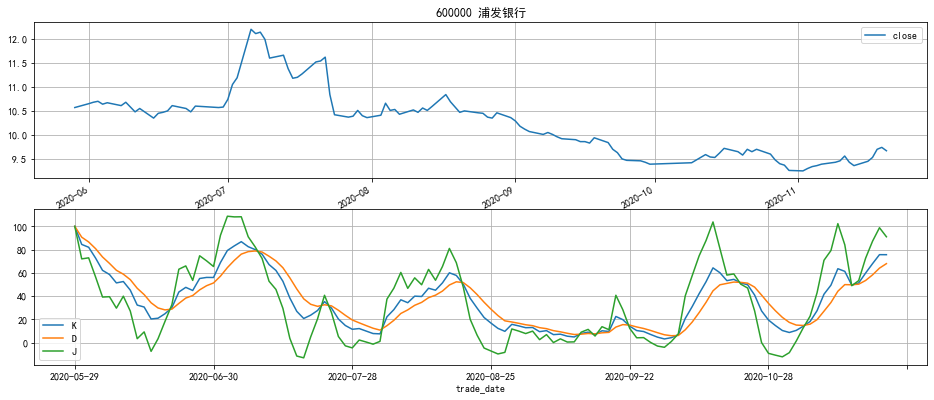

In [10]:
print(dw[-3:])

df.index = pd.to_datetime(df.trade_date)
# 画股票收盘价图
fig,axes = plt.subplots(2,1)
df[['close']].plot(ax=axes[0], grid=True, title=stock_code+" "+stock_name, figsize=(16,7))
# 画 KDJ 曲线图
dw[['K','D','J']].plot(ax=axes[1], grid=True)
plt.show()

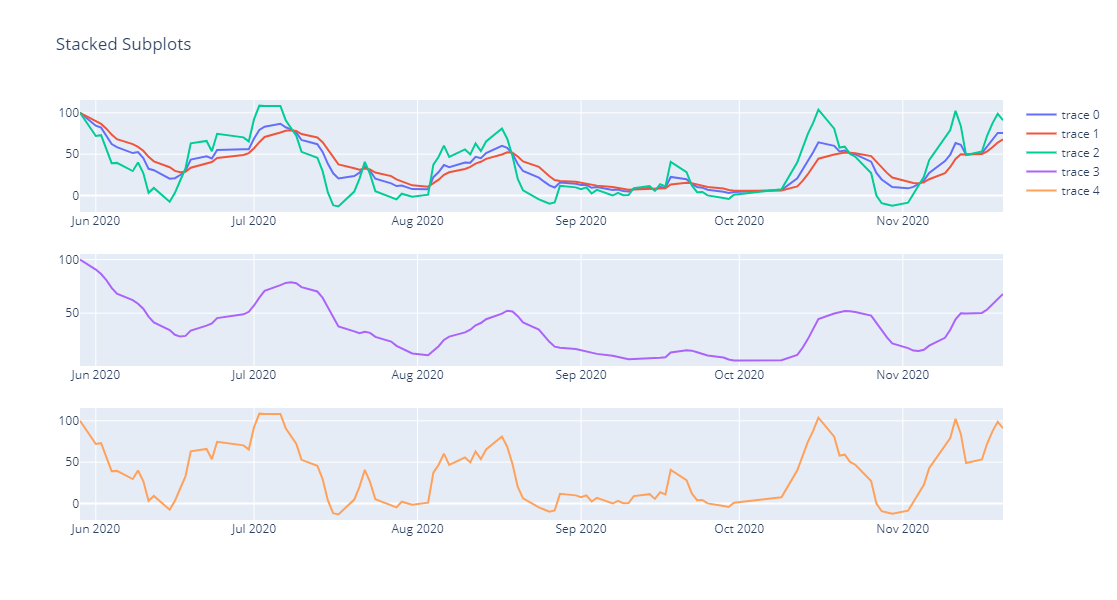

In [14]:
pd.options.plotting.backend = "plotly"
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1)
fig.append_trace(go.Scatter( x=dw['trade_date'], y=dw['K'],) , row=1, col=1)
fig.append_trace(go.Scatter( x=dw['trade_date'], y=dw['D'],) , row=1, col=1)
fig.append_trace(go.Scatter( x=dw['trade_date'], y=dw['J'],) , row=1, col=1)
fig.append_trace(go.Scatter( x=dw['trade_date'], y=dw['D'],) , row=2, col=1)
fig.append_trace(go.Scatter( x=dw['trade_date'], y=dw['J']) , row=3, col=1)

fig.update_layout(height=600, width=600, title_text="Stacked Subplots")
fig.show()